In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mutual_info_score, brier_score_loss, mean_squared_error
from scipy.special import kl_div
from functools import reduce
import glob
from tqdm import tqdm
tqdm.pandas()
import warnings
from datasets import load_dataset
import os
from scipy.stats import entropy, norm

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# Baseline 1: Ensemble of Adapters

In [3]:
reward_files = glob.glob('/users/lucelo/UQLRM/metadata_single_mlp_*.tsv')
reward_dfs = []
for file in reward_files:
    df = pd.read_csv(file, sep='\t', header=0)[['id', 'RewardScore', 'Dataset', 'Preference']]
    chosen_df = df[df['Preference'] == 'chosen'].rename(columns={'RewardScore': 'RewardChosen'})
    rejected_df = df[df['Preference'] == 'rejected'].rename(columns={'RewardScore': 'RewardRejected'})
    merged_df = chosen_df.merge(rejected_df, on=['id', 'Dataset'], how='inner')
    merged_df['RewardDiff'] = merged_df['RewardChosen'] - merged_df['RewardRejected']
    merged_df['PreferenceProb'] = sigmoid(merged_df['RewardDiff'])
    reward_dfs.append(merged_df)

for i, df in enumerate(reward_dfs):
    # Add unique suffixes to the column names
    df.columns = [f"{col}_{i}" if col != 'id' else col for col in df.columns]

final_rewards =  pd.concat(reward_dfs, axis=1)
N = len(reward_dfs)

In [4]:
def compute_rw_distinct_pairs(final_rewards, N):
    pairs = [(i, j) for i in range(N) for j in range(N)]
    def compute_rw_diff_pairs(x):
        # np.random.shuffle(pairs)
        # pairs = pairs[:N]
        diffs = []
        for pair in pairs:
            i,j = pair
            diffs.append(x[f'RewardChosen_{i}'] - x[f'RewardRejected_{j}'])
        return np.var(diffs)
        
    return final_rewards.progress_apply(lambda x: compute_rw_diff_pairs(x), axis=1)

final_rewards['RwDiffDistinctPairs'] = compute_rw_distinct_pairs(final_rewards, len(reward_dfs))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16123/16123 [02:18<00:00, 116.45it/s]


In [5]:
def compute_reward_covariance(final_rewards):
    covariances = []
    for index, row in final_rewards.iterrows():
        rejected = [row[f'RewardRejected_{n}'] for n in range(len(reward_dfs))]
        chosen = [row[f'RewardChosen_{i}'] for i in range(len(reward_dfs))]
        covariance = np.cov(rejected, chosen)[0][1]
        covariances.append(covariance)
    return covariances

final_rewards['Covariance'] = compute_reward_covariance(final_rewards)

In [6]:
def compute_unc_stats(final_rewards):
    # 1. Reward Statistics
    final_rewards['RwAverage'] = final_rewards.filter(like="Reward", axis=1).mean(axis=1)
    final_rewards['RwVariance'] = final_rewards.filter(like="Reward", axis=1).var(axis=1)
    
    # 2. "Chosen" Reward Statistics
    final_rewards['RwChosenAverage'] = final_rewards.filter(like="RewardChosen", axis=1).mean(axis=1)
    final_rewards['RwChosenVariance'] = final_rewards.filter(like="RewardChosen", axis=1).var(axis=1)
    
    # 3. "Rejected" Reward Statistics
    final_rewards['RwRejectedAverage'] = final_rewards.filter(like="RewardRejected", axis=1).mean(axis=1)
    final_rewards['RwRejectedVariance'] = final_rewards.filter(like="RewardRejected", axis=1).var(axis=1)
    
    # 4. Reward Diff (r_chosen - r_rejected) Statistics
    final_rewards['RwDiffAverage'] = final_rewards.filter(like="RewardDiff", axis=1).mean(axis=1)
    final_rewards['RwDiffVariance'] = final_rewards.filter(like="RewardDiff", axis=1).var(axis=1)
    
    # 5. Variance Sum = Var(r_chosen) + Var(r_rejected)
    final_rewards['RwVarianceSum'] = final_rewards['RwChosenVariance'] + final_rewards['RwRejectedVariance']
    
    # 6. Var(r_chosen, r_rejected) = Var(r_chosen) - Var(r_rejected) - 2*Cov(r_chosen, r_rejected)
    # This is an analytical version of Variance computed in #4
    final_rewards['RwDiffAnalyticalVariance'] = final_rewards['RwChosenVariance'] + final_rewards['RwRejectedVariance'] - 2*final_rewards['Covariance']
    
    # 7. Var(p), p = sigmoid(r_chosen - r_rejected) (Preference Probability)
    final_rewards['PrefProbVariance'] = final_rewards.filter(like="PreferenceProb", axis=1).var(axis=1)
    final_rewards['PrefProbAverage'] = final_rewards.filter(like="PreferenceProb", axis=1).mean(axis=1)
    
    # 8. Max Variance = max(Var(r_chosen), Var(r_rejected))
    final_rewards['RewardMaxVariance'] = final_rewards[['RwChosenVariance', 'RwRejectedVariance']].max(axis=1)

    #9. Max Prediction Interval
    final_rewards['MaxPrefInterval'] = final_rewards.filter(like="PreferenceProb", axis=1).max(axis=1) - final_rewards.filter(like="PreferenceProb", axis=1).min(axis=1)

In [7]:
compute_unc_stats(final_rewards)

In [8]:
final_rewards.head()

,id,RewardChosen_0,Dataset_0,Preference_x_0,RewardRejected_0,Preference_y_0,RewardDiff_0,PreferenceProb_0,id,RewardChosen_1,...,RwRejectedAverage,RwRejectedVariance,RwDiffAverage,RwDiffVariance,RwVarianceSum,RwDiffAnalyticalVariance,PrefProbVariance,PrefProbAverage,RewardMaxVariance,MaxPrefInterval
0,1801,-1.021655,train,chosen,-1.308317,rejected,0.286662,0.571179,1801,-1.198608,...,-1.222914,0.024675,0.259599,0.029189,0.042980,0.029189,0.001746,0.564097,0.024675,0.174546
1,87053,1.413000,train,chosen,-0.526894,rejected,1.939894,0.874340,87053,1.505481,...,-0.579809,0.024868,1.808733,0.019871,0.043450,0.019871,0.000291,0.858371,0.024868,0.064916
2,59149,-0.104880,train,chosen,-0.680847,rejected,0.575967,0.640139,59149,0.134865,...,-0.488183,0.020723,0.620937,0.018558,0.042683,0.018558,0.000957,0.649819,0.021960,0.121001
3,20080,1.230862,train,chosen,-2.328661,rejected,3.559523,0.972335,20080,1.231286,...,-2.121717,0.018112,3.213534,0.030726,0.034659,0.030726,0.000047,0.960816,0.018112,0.032511
4,72323,0.448723,train,chosen,-0.174440,rejected,0.623163,0.650938,72323,0.188774,...,-0.180517,0.026328,0.469449,0.035856,0.053090,0.035856,0.002010,0.614342,0.026763,0.193187


<Axes: >

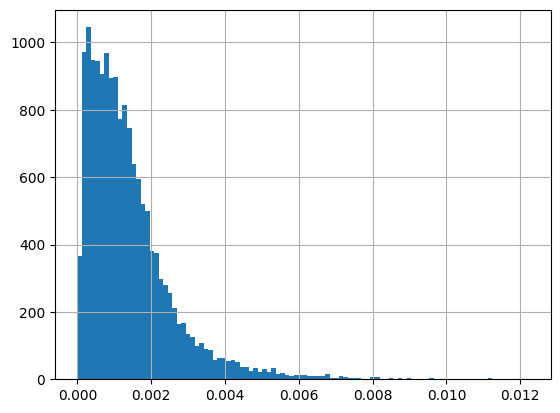

In [9]:
final_rewards['PrefProbVariance'].hist(bins=100)

<Axes: >

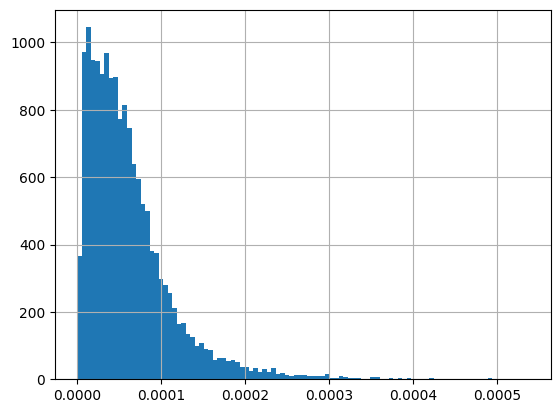

In [10]:
normalized_probs = final_rewards['PrefProbVariance'] / final_rewards['PrefProbVariance'].sum()
normalized_probs.hist(bins=100)

In [11]:
def softmax(x, temperature=0.5):
    e_x = np.exp(x / temperature)
    return e_x / e_x.sum(axis=0)

<Axes: >

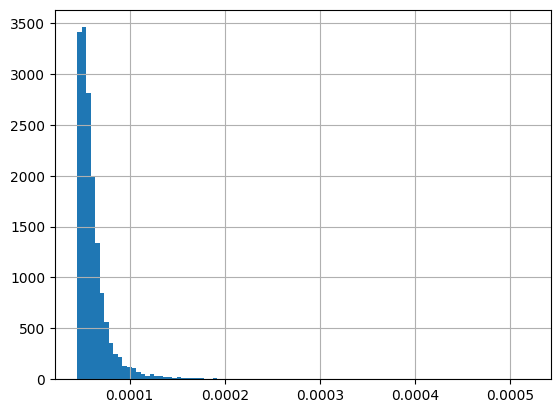

In [12]:
soft_probs = softmax(final_rewards['PrefProbVariance'], temperature=0.005)
soft_probs.hist(bins=100)

In [13]:
def compute_ce(final_rewards):
    final_rewards['Error'] = (final_rewards['PrefProbAverage'] < 0.5) * 1.0
    final_rewards['GT'] = 1.0
    final_rewards['CrossEntropy'] = kl_div(final_rewards['GT'], final_rewards['PrefProbAverage'])
    final_rewards['BrierScore'] = (final_rewards['GT'] - final_rewards['PrefProbAverage'])**2

In [14]:
compute_ce(final_rewards)

In [15]:
final_rewards.head()

,id,RewardChosen_0,Dataset_0,Preference_x_0,RewardRejected_0,Preference_y_0,RewardDiff_0,PreferenceProb_0,id,RewardChosen_1,...,RwVarianceSum,RwDiffAnalyticalVariance,PrefProbVariance,PrefProbAverage,RewardMaxVariance,MaxPrefInterval,Error,GT,CrossEntropy,BrierScore
0,1801,-1.021655,train,chosen,-1.308317,rejected,0.286662,0.571179,1801,-1.198608,...,0.042980,0.029189,0.001746,0.564097,0.024675,0.174546,0.0,1.0,0.136626,0.190012
1,87053,1.413000,train,chosen,-0.526894,rejected,1.939894,0.874340,87053,1.505481,...,0.043450,0.019871,0.000291,0.858371,0.024868,0.064916,0.0,1.0,0.011090,0.020059
2,59149,-0.104880,train,chosen,-0.680847,rejected,0.575967,0.640139,59149,0.134865,...,0.042683,0.018558,0.000957,0.649819,0.021960,0.121001,0.0,1.0,0.080880,0.122626
3,20080,1.230862,train,chosen,-2.328661,rejected,3.559523,0.972335,20080,1.231286,...,0.034659,0.030726,0.000047,0.960816,0.018112,0.032511,0.0,1.0,0.000788,0.001535
4,72323,0.448723,train,chosen,-0.174440,rejected,0.623163,0.650938,72323,0.188774,...,0.053090,0.035856,0.002010,0.614342,0.026763,0.193187,0.0,1.0,0.101546,0.148732


In [16]:
def split_dataset(final_rewards, dataset_column):
    train_df = final_rewards[final_rewards[dataset_column] == 'train']
    test_df = final_rewards[final_rewards[dataset_column] == 'test']
    eval_df = final_rewards[final_rewards[dataset_column] == 'eval']
    ood_df = final_rewards[final_rewards[dataset_column] == 'ood']
    return train_df, test_df, eval_df, ood_df

In [17]:
train_df, test_df, eval_df, ood_df = split_dataset(final_rewards, "Dataset_0")

In [18]:
def compute_quantiles(train_df):
    chosen_p5 = train_df['RwChosenAverage'].quantile(0.05)
    chosen_p95 = train_df['RwChosenAverage'].quantile(0.95)
    
    rej_p5 = train_df['RwRejectedAverage'].quantile(0.05)
    rej_p95 = train_df['RwRejectedAverage'].quantile(0.95)
    
    print(chosen_p5, chosen_p95)
    print(rej_p5, rej_p95)
    return chosen_p5, chosen_p95, rej_p5, rej_p95

def compute_outlier_unc(final_rewards, chosen_p5, chosen_p95, rej_p5, rej_p95):
    # Heuristic: Get p5 and p95 in reward distributions (aka GDA)
    final_rewards['TooHighOrTooLow'] = ((final_rewards['RwChosenAverage'] > chosen_p95) | (final_rewards['RwChosenAverage'] < chosen_p5) | (final_rewards['RwRejectedAverage'] < rej_p5) | (final_rewards['RwRejectedAverage'] > rej_p95)) * 1.0

chosen_p5, chosen_p95, rej_p5, rej_p95 = compute_quantiles(train_df)
compute_outlier_unc(final_rewards, chosen_p5, chosen_p95, rej_p5, rej_p95)

-1.6882672519297213 1.7828431959087783
-2.311974043781693 1.3708552275155041


In [19]:
def compute_gaussian_prob(df, pred_column, mean, std):
    # Fit a Gaussian density with these parameters
    gaussian_density = norm(loc=mean, scale=std)

    # Return the probability associated with a new point s in this Gaussian
    df[f'GDA_{pred_column}_Prob'] = df[pred_column].apply(gaussian_density.pdf)
    df[f'GDA_{pred_column}_alpha'] = df[f'GDA_{pred_column}_Prob'].apply(lambda x: x if x < 0.5 else 1 - x)

In [20]:
mean_chosen = train_df['RwChosenAverage'].mean()
std_chosen = train_df['RwChosenAverage'].std()

mean_rejected = train_df['RwRejectedAverage'].mean()
std_rejected = train_df['RwRejectedAverage'].std()

compute_gaussian_prob(final_rewards, "RwChosenAverage", mean_chosen, std_chosen)
compute_gaussian_prob(final_rewards, "RwRejectedAverage", mean_rejected, std_rejected)

In [21]:
final_rewards.head(100)

,id,RewardChosen_0,Dataset_0,Preference_x_0,RewardRejected_0,Preference_y_0,RewardDiff_0,PreferenceProb_0,id,RewardChosen_1,...,MaxPrefInterval,Error,GT,CrossEntropy,BrierScore,TooHighOrTooLow,GDA_RwChosenAverage_Prob,GDA_RwChosenAverage_alpha,GDA_RwRejectedAverage_Prob,GDA_RwRejectedAverage_alpha
0,1801,-1.021655,train,chosen,-1.308317,rejected,0.286662,0.571179,1801,-1.198608,...,0.174546,0.0,1.0,0.136626,0.190012,0.0,0.217420,0.217420,0.281609,0.281609
1,87053,1.413000,train,chosen,-0.526894,rejected,1.939894,0.874340,87053,1.505481,...,0.064916,0.0,1.0,0.011090,0.020059,0.0,0.223827,0.223827,0.351744,0.351744
2,59149,-0.104880,train,chosen,-0.680847,rejected,0.575967,0.640139,59149,0.134865,...,0.121001,0.0,1.0,0.080880,0.122626,0.0,0.372784,0.372784,0.353587,0.353587
3,20080,1.230862,train,chosen,-2.328661,rejected,3.559523,0.972335,20080,1.231286,...,0.032511,0.0,1.0,0.000788,0.001535,0.0,0.252674,0.252674,0.119711,0.119711
4,72323,0.448723,train,chosen,-0.174440,rejected,0.623163,0.650938,72323,0.188774,...,0.193187,0.0,1.0,0.101546,0.148732,0.0,0.369601,0.369601,0.342887,0.342887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,80580,1.554397,train,chosen,1.008231,rejected,0.546165,0.633245,80580,1.649850,...,0.099772,0.0,1.0,0.070629,0.109103,0.0,0.146877,0.146877,0.170765,0.170765
96,52285,0.859001,train,chosen,-1.549616,rejected,2.408617,0.917482,52285,0.817228,...,0.075008,0.0,1.0,0.003974,0.007487,0.0,0.289912,0.289912,0.236659,0.236659
97,50293,1.536220,train,chosen,-1.667574,rejected,3.203794,0.960977,50293,1.728942,...,0.023557,0.0,1.0,0.000902,0.001754,0.0,0.141012,0.141012,0.231813,0.231813
98,32555,-1.131761,train,chosen,-1.406382,rejected,0.274621,0.568227,32555,-1.001117,...,0.129487,0.0,1.0,0.108164,0.156795,0.0,0.189364,0.189364,0.227300,0.227300


In [40]:
train_df, test_df, eval_df, ood_df = split_dataset(final_rewards, "Dataset_0")
# Compute Variances 
def compute_stats_ce_correlation(df, mode="train", ensemble=True):
    print(f"Correlation Between Var(r1) + Var(r2) and Cross Entropy for {mode}: {df['RwVarianceSum'].corr(df['CrossEntropy'], method='spearman')}")
    print(f"Correlation Between Var(r1-r2) and CrossEntropy for {mode}: {df['RwDiffVariance'].corr(df['CrossEntropy'], method='spearman')}")
    print(f"Correlation Between Var(p) and Error for {mode}: {df['PrefProbVariance'].corr(df['Error'], method='spearman')}")
    print(f"Correlation Between max(Var(r1), Var(r2)) and Cross Entropy for {mode}: {df['RewardMaxVariance'].corr(df['CrossEntropy'], method='spearman')}")
    print(f"Correlation Between and |p_max - p_min| and Error for {mode}: {df['MaxPrefInterval'].corr(df['Error'], method='spearman')}")
    if ensemble:
        print(f"Correlation Between Var(r1-r2, *) and Cross Entropy for {mode}: {df['RwDiffDistinctPairs'].corr(df['CrossEntropy'], method='spearman')}")
        print(f"Correlation Between TooHighTooLow and Cross Entropy for {mode}: {df['TooHighOrTooLow'].corr(df['CrossEntropy'], method='spearman')}")
        print(f"Correlation Between GDA_Chosen_Prob and Cross Entropy for {mode}: {df['GDA_RwChosenAverage_Prob'].corr(df['CrossEntropy'], method='spearman')}")
        print(f"Correlation Between GDA_Rejected_Prob and Cross Entropy for {mode}: {df['GDA_RwRejectedAverage_Prob'].corr(df['CrossEntropy'], method='spearman')}")
        print(f"Correlation Between GDA_Chosen_alpha and Cross Entropy for {mode}: {df['GDA_RwChosenAverage_alpha'].corr(df['CrossEntropy'], method='spearman')}")
        print(f"Correlation Between GDA_Rejected_alpha and Cross Entropy for {mode}: {df['GDA_RwRejectedAverage_alpha'].corr(df['CrossEntropy'], method='spearman')}")
        
    
print("Train Dataset")
compute_stats_ce_correlation(train_df, "train")
print("Test Dataset")
compute_stats_ce_correlation(test_df, "test")
print("Eval Dataset")
compute_stats_ce_correlation(eval_df, "eval")
print("OOD Dataset")
compute_stats_ce_correlation(ood_df, "ood")

Train Dataset
Correlation Between Var(r1) + Var(r2) and Cross Entropy for train: 0.04154004075548281
Correlation Between Var(r1-r2) and CrossEntropy for train: -0.09365878075551694
Correlation Between Var(p) and Error for train: 0.20166718376471401
Correlation Between max(Var(r1), Var(r2)) and Cross Entropy for train: -0.013535195798154634
Correlation Between and |p_max - p_min| and Error for train: 0.19557532967222443
Correlation Between Var(r1-r2, *) and Cross Entropy for train: 0.0415400321483095
Correlation Between TooHighTooLow and Cross Entropy for train: 0.03256358691461575
Correlation Between GDA_Chosen_Prob and Cross Entropy for train: -0.06876185233774851
Correlation Between GDA_Rejected_Prob and Cross Entropy for train: 0.0206490385863076
Correlation Between GDA_Chosen_alpha and Cross Entropy for train: -0.06876185233774851
Correlation Between GDA_Rejected_alpha and Cross Entropy for train: 0.0206490385863076
Test Dataset
Correlation Between Var(r1) + Var(r2) and Cross Entro

In [24]:
# Compute Variances 
def compute_stats_brier_correlation(df, mode="train", ensemble=True):
    print(f"Correlation Between Var(r1) + Var(r2) and Brier Score for {mode}: {df['RwVarianceSum'].corr(df['BrierScore'], method='spearman')}")
    print(f"Correlation Between Var(r1-r2) and Brier Score for {mode}: {df['RwDiffVariance'].corr(df['BrierScore'], method='spearman')}")
    print(f"Correlation Between Var(p) and Brier Score for {mode}: {df['PrefProbVariance'].corr(df['BrierScore'], method='spearman')}")
    print(f"Correlation Between max(Var(r1), Var(r2)) and Brier Score for {mode}: {df['RewardMaxVariance'].corr(df['BrierScore'], method='spearman')}")
    if ensemble:
        print(f"Correlation Between Var(r1-r2, *) and Brier Score for {mode}: {df['RwDiffDistinctPairs'].corr(df['BrierScore'], method='spearman')}")
        print(f"Correlation Between TooHighTooLow and Brier Score for {mode}: {df['TooHighOrTooLow'].corr(df['BrierScore'], method='spearman')}")
    
print("Train Dataset")
compute_stats_brier_correlation(train_df, "train")
print("Test Dataset")
compute_stats_brier_correlation(test_df, "test")
print("Eval Dataset")
compute_stats_brier_correlation(eval_df, "eval")
print("OOD Dataset")
compute_stats_brier_correlation(ood_df, "ood")

Train Dataset
Correlation Between Var(r1) + Var(r2) and Brier Score for train: 0.04154004075548281
Correlation Between Var(r1-r2) and Brier Score for train: -0.09365878075551694
Correlation Between Var(p) and Brier Score for train: 0.4840945267028453
Correlation Between max(Var(r1), Var(r2)) and Brier Score for train: -0.013535195798154634
Correlation Between Var(r1-r2, *) and Brier Score for train: 0.0415400321483095
Correlation Between TooHighTooLow and Brier Score for train: 0.03256358691461575
Test Dataset
Correlation Between Var(r1) + Var(r2) and Brier Score for test: 0.01696573905824865
Correlation Between Var(r1-r2) and Brier Score for test: -0.10864997466387988
Correlation Between Var(p) and Brier Score for test: 0.322236670433129
Correlation Between max(Var(r1), Var(r2)) and Brier Score for test: -0.03576840148701882
Correlation Between Var(r1-r2, *) and Brier Score for test: 0.016966621773111475
Correlation Between TooHighTooLow and Brier Score for test: 0.10736765676813996
E

# Baseline 2: Variational Inference

In [27]:
vpo_df = pd.read_csv('/users/lucelo/UQLRM/metadata_vpo.tsv', sep='\t', header=0)

In [28]:
chosen_df = vpo_df[vpo_df['Preference'] == 'chosen'].rename(columns={'RewardScoreMean': 'RewardChosenMean', 'RewardScoreVar': 'RewardChosenVar'})
rejected_df = vpo_df[vpo_df['Preference'] == 'rejected'].rename(columns={'RewardScoreMean': 'RewardRejectedMean', 'RewardScoreVar': 'RewardRejectedVar'})
final_vpo_df = chosen_df.merge(rejected_df, on=['id', 'Dataset'], how='inner')
final_vpo_df['RewardDiff'] = final_vpo_df['RewardChosenMean'] - final_vpo_df['RewardRejectedMean']
final_vpo_df['PrefProbAverage'] = sigmoid(final_vpo_df['RewardDiff'])

In [29]:
def compute_rw_diff_var(x):
    chosen_mu = x['RewardChosenMean']
    chosen_var = x['RewardChosenVar']
    chosen_points = np.random.normal(chosen_mu, np.sqrt(chosen_var), 1000)

    rejected_mu = x['RewardRejectedMean']
    rejected_var = x['RewardRejectedVar']
    rejected_points = np.random.normal(rejected_mu, np.sqrt(rejected_var), 1000)

    diff = chosen_points - rejected_points
    probs = sigmoid(diff)
    return pd.Series([np.mean(diff), np.var(diff), np.mean(probs), np.var(probs)])

In [30]:
final_vpo_df.head()

,Preference_x,RewardChosenMean,RewardChosenVar,Model_x,Dataset,id,Preference_y,RewardRejectedMean,RewardRejectedVar,Model_y,RewardDiff,PrefProbAverage
0,chosen,0.217773,0.474215,vpo,train,0,rejected,-0.398438,0.459625,vpo,0.616211,0.649356
1,chosen,-1.054688,0.461424,vpo,train,1,rejected,0.122070,0.474215,vpo,-1.176758,0.235636
2,chosen,-0.306641,0.450735,vpo,train,2,rejected,-0.314453,0.457833,vpo,0.007812,0.501953
3,chosen,-1.054688,0.461424,vpo,train,3,rejected,-0.445312,0.447228,vpo,-0.609375,0.352202
4,chosen,-1.054688,0.461424,vpo,train,4,rejected,-0.453125,0.454270,vpo,-0.601562,0.353986


In [31]:
def compute_unc_stats_vi(vpo_df):
    # 4. Reward Diff (r_chosen - r_rejected) Statistics
    vpo_df[['RwDiffAverage', 'RwDiffVariance', 'PrefProbAverage', 'PrefProbVariance']] = vpo_df.apply(lambda x: compute_rw_diff_var(x), axis=1)
    
    # 5. Variance Sum = Var(r_chosen) + Var(r_rejected)
    vpo_df['RwVarianceSum'] = vpo_df['RewardChosenVar'] + vpo_df['RewardRejectedVar']
    
    # 8. Max Variance = max(Var(r_chosen), Var(r_rejected))
    vpo_df['RewardMaxVariance'] = vpo_df[['RewardChosenVar', 'RewardRejectedVar']].max(axis=1)

compute_unc_stats_vi(final_vpo_df)

In [32]:
final_vpo_df.head()

,Preference_x,RewardChosenMean,RewardChosenVar,Model_x,Dataset,id,Preference_y,RewardRejectedMean,RewardRejectedVar,Model_y,RewardDiff,PrefProbAverage,RwDiffAverage,RwDiffVariance,PrefProbVariance,RwVarianceSum,RewardMaxVariance
0,chosen,0.217773,0.474215,vpo,train,0,rejected,-0.398438,0.459625,vpo,0.616211,0.628106,0.636186,0.971300,0.038298,0.933841,0.474215
1,chosen,-1.054688,0.461424,vpo,train,1,rejected,0.122070,0.474215,vpo,-1.176758,0.270729,-1.171465,0.903217,0.027886,0.935640,0.474215
2,chosen,-0.306641,0.450735,vpo,train,2,rejected,-0.314453,0.457833,vpo,0.007812,0.509090,0.039460,0.870322,0.038884,0.908569,0.457833
3,chosen,-1.054688,0.461424,vpo,train,3,rejected,-0.445312,0.447228,vpo,-0.609375,0.377058,-0.590879,0.835134,0.034991,0.908652,0.461424
4,chosen,-1.054688,0.461424,vpo,train,4,rejected,-0.453125,0.454270,vpo,-0.601562,0.385717,-0.552088,0.878495,0.036054,0.915695,0.461424


In [36]:
compute_ce(final_vpo_df)
vpo_train_df, vpo_test_df, vpo_eval_df, vpo_ood_df = split_dataset(final_vpo_df, "Dataset")

In [39]:
print("Train Dataset")
compute_stats_ce_correlation(vpo_train_df, "train", ensemble=False)
print("Test Dataset")
compute_stats_ce_correlation(vpo_test_df, "test", ensemble=False)
print("Eval Dataset")
compute_stats_ce_correlation(vpo_eval_df, "eval", ensemble=False)
print("OOD Dataset")
compute_stats_ce_correlation(vpo_ood_df, "ood", ensemble=False)

Train Dataset
Correlation Between Var(r1) + Var(r2) and Cross Entropy for train: -0.07263562129560804
Correlation Between Var(r1-r2) and Error for train: -0.017003221343124954
Correlation Between Var(p) and Cross Entropy for train: 0.6607520541665648
Correlation Between max(Var(r1), Var(r2)) and Cross Entropy for train: -0.09117890920300704


KeyError: 'MaxPrefInterval'

In [75]:
print("Train Dataset")
compute_stats_brier_correlation(vpo_train_df, "train", ensemble=False)
print("Test Dataset")
compute_stats_brier_correlation(vpo_test_df, "test", ensemble=False)
print("Eval Dataset")
compute_stats_brier_correlation(vpo_eval_df, "eval", ensemble=False)
print("OOD Dataset")
compute_stats_brier_correlation(vpo_ood_df, "ood", ensemble=False)

Train Dataset
Correlation Between Var(r1) + Var(r2) and Brier Score for train: -0.07242801215116604
Correlation Between Var(r1-r2) and Brier Score for train: -0.03854055980902226
Correlation Between Var(p) and Brier Score for train: 0.6605964905804889
Correlation Between max(Var(r1), Var(r2)) and Brier Score for train: -0.09096605762816938
Test Dataset
Correlation Between Var(r1) + Var(r2) and Brier Score for test: -0.0018904309537869208
Correlation Between Var(r1-r2) and Brier Score for test: 0.0016976488094075535
Correlation Between Var(p) and Brier Score for test: 0.4784675079243519
Correlation Between max(Var(r1), Var(r2)) and Brier Score for test: -0.023769930365107186
Eval Dataset
Correlation Between Var(r1) + Var(r2) and Brier Score for eval: -0.03186996336372765
Correlation Between Var(r1-r2) and Brier Score for eval: -0.015365901395559713
Correlation Between Var(p) and Brier Score for eval: 0.45071649727010993
Correlation Between max(Var(r1), Var(r2)) and Brier Score for eval:

# Baseline 3: Finetuned Ensembles

In [25]:
def compute_entropy(df):
    return df.apply(lambda row: entropy(row), axis=1)
    
def compute_uncertanties(dfs):
    # Compute single model entropies
    for df in dfs:
        df['entropy'] = compute_entropy(df[['First', 'Second']])
    
    
    for i, df in enumerate(dfs):
        # Add unique suffixes to the column names
        df.columns = [f"{col}_{i}" if col != 'id' else col for col in df.columns]

    # Use reduce to merge all dataframes
    from functools import reduce
    final_df = reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)

    first_cols = [col for col in final_df.columns if 'First_' in col]
    second_cols = [col for col in final_df.columns if 'Second_' in col]
    entropy_cols = [col for col in final_df.columns if 'entropy_' in col]

    avg_first = final_df[first_cols].mean(axis=1)
    avg_second = final_df[second_cols].mean(axis=1)
    avg_entropy = final_df[entropy_cols].mean(axis=1)
    var_first = final_df[first_cols].var(axis=1)
    avg_df = pd.concat([avg_first, avg_second, avg_entropy, var_first], axis=1)
    avg_df.columns = ['First', 'Second', 'Aleatoric Uncertainty', 'Variance']

    
    avg_df['Predictive Uncertainty'] = compute_entropy(avg_df[['First', 'Second']])
    avg_df['Epistemic Uncertainty'] = avg_df['Predictive Uncertainty'] - avg_df['Aleatoric Uncertainty']
    return avg_df['Epistemic Uncertainty'], avg_df['Predictive Uncertainty'], avg_df['Aleatoric Uncertainty'], avg_df[['First', 'Second']], avg_df['Variance']

In [26]:
!huggingface-cli login --token $HUGGINGFACE_WRITETOKEN
def load_predictions(exp_prefix, name, checkpoint, mode, ensemble_size, active_learning=False):
    ensemble_df = []
    for j in range(ensemble_size):
        if active_learning:
            datafile = os.path.join(exp_prefix, f"{name}", "predictions", f"{name}_{j}", f"checkpoint-{i}", f"eval_{mode}", "predictions.csv")
        else:
            datafile = os.path.join(exp_prefix, f"{name}_{j}", f"{name}_{j}", f"checkpoint-{i}", f"eval_{mode}", "predictions.csv")
        df = load_dataset("luckeciano/uqlrm_predictions", data_files=datafile)['train'].to_pandas()
        ensemble_df.append(df)


    print(f"Number of ensemble predictions loaded: {len(ensemble_df)}")
    epistemic, predictive, aleatoric, ens_predictions, var_predictions = compute_uncertanties(ensemble_df)
    return ens_predictions, var_predictions
    
exp_prefix = "scratch/lucelo/sft/results/"
name = "gpt2_rwft_reddit_1"
i = 80
train_ens_preds, train_var_preds = load_predictions(exp_prefix, name, i, "train", 8)
test_ens_preds, test_var_preds = load_predictions(exp_prefix, name, i, "test", 8)
eval_ens_preds, eval_var_preds = load_predictions(exp_prefix, name, i, "eval", 8)
ood_ens_preds, ood_var_preds = load_predictions(exp_prefix, name, i, "ood", 8)
    

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /scratch-ssd/oatml/huggingface/token
Login successful
Number of ensemble predictions loaded: 8
Number of ensemble predictions loaded: 8
Number of ensemble predictions loaded: 8
Number of ensemble predictions loaded: 8


In [41]:
def compute_ce_ens(ens_preds, var_preds):
    finetune_ens_df = pd.DataFrame()
    finetune_ens_df['PrefProbAverage'] = ens_preds['First']
    finetune_ens_df['PrefProbVariance'] = var_preds
    finetune_ens_df['Error'] = (finetune_ens_df['PrefProbAverage'] < 0.5) * 1.0
    finetune_ens_df['GT'] = 1.0
    finetune_ens_df['CrossEntropy'] = kl_div(finetune_ens_df['GT'], finetune_ens_df['PrefProbAverage'])
    finetune_ens_df['BrierScore'] = brier_score_loss(finetune_ens_df['GT'], finetune_ens_df['PrefProbAverage'])
    return finetune_ens_df

In [28]:
train_df = compute_ce_ens(train_ens_preds, train_var_preds)
print(f"Correlation Between Var(p) and Cross Entropy for Training: {train_df['PrefProbVariance'].corr(train_df['CrossEntropy'], method='spearman')}")

test_df = compute_ce_ens(test_ens_preds, test_var_preds)
print(f"Correlation Between Var(p) and Cross Entropy for Training: {test_df['PrefProbVariance'].corr(test_df['CrossEntropy'], method='spearman')}")

eval_df = compute_ce_ens(eval_ens_preds, eval_var_preds)
print(f"Correlation Between Var(p) and Cross Entropy for Training: {eval_df['PrefProbVariance'].corr(eval_df['CrossEntropy'], method='spearman')}")

ood_df = compute_ce_ens(ood_ens_preds, ood_var_preds)
print(f"Correlation Between Var(p) and Cross Entropy for Training: {ood_df['PrefProbVariance'].corr(ood_df['CrossEntropy'], method='spearman')}")

Correlation Between Var(p) and Cross Entropy for Training: 0.056321783544015507
Correlation Between Var(p) and Cross Entropy for Training: 0.07439719985948799
Correlation Between Var(p) and Cross Entropy for Training: 0.05166463652945645
Correlation Between Var(p) and Cross Entropy for Training: -0.07087779592929311


In [ ]:
print(f"Correlation Between Var(p) and Brier Score for Training: {train_df['PrefProbVariance'].corr(train_df['BrierScore'], method='spearman')}")

print(f"Correlation Between Var(p) and Brier Score for Training: {test_df['PrefProbVariance'].corr(test_df['BrierScore'], method='spearman')}")

print(f"Correlation Between Var(p) and Brier Score for Training: {eval_df['PrefProbVariance'].corr(eval_df['BrierScore'], method='spearman')}")

print(f"Correlation Between Var(p) and Brier Score for Training: {ood_df['PrefProbVariance'].corr(ood_df['BrierScore'], method='spearman')}")

In [29]:
exp_prefix = "scratch/lucelo/active_learning/results/"
name = "al_ep_v11_3"
i = 60
train_ens_preds, train_var_preds = load_predictions(exp_prefix, name, i, "train", 8, active_learning=True)
test_ens_preds, test_var_preds = load_predictions(exp_prefix, name, i, "test", 8, active_learning=True)
eval_ens_preds, eval_var_preds = load_predictions(exp_prefix, name, i, "eval", 8, active_learning=True)
ood_ens_preds, ood_var_preds = load_predictions(exp_prefix, name, i, "ood", 8, active_learning=True)

Number of ensemble predictions loaded: 8
Number of ensemble predictions loaded: 8
Number of ensemble predictions loaded: 8
Number of ensemble predictions loaded: 8


In [30]:
train_df = compute_ce_ens(train_ens_preds, train_var_preds)
print(f"Correlation Between Var(p) and Cross Entropy for Training: {train_df['PrefProbVariance'].corr(train_df['CrossEntropy'], method='spearman')}")

test_df = compute_ce_ens(test_ens_preds, test_var_preds)
print(f"Correlation Between Var(p) and Cross Entropy for Training: {test_df['PrefProbVariance'].corr(test_df['CrossEntropy'], method='spearman')}")

eval_df = compute_ce_ens(eval_ens_preds, eval_var_preds)
print(f"Correlation Between Var(p) and Cross Entropy for Training: {eval_df['PrefProbVariance'].corr(eval_df['CrossEntropy'], method='spearman')}")

ood_df = compute_ce_ens(ood_ens_preds, ood_var_preds)
print(f"Correlation Between Var(p) and Cross Entropy for Training: {ood_df['PrefProbVariance'].corr(ood_df['CrossEntropy'], method='spearman')}")

Correlation Between Var(p) and Cross Entropy for Training: -0.09131798391076847
Correlation Between Var(p) and Cross Entropy for Training: -0.014102754498991945
Correlation Between Var(p) and Cross Entropy for Training: 0.006720589136532155
Correlation Between Var(p) and Cross Entropy for Training: -0.11646054855009284


In [ ]:
print(f"Correlation Between Var(p) and Brier Score for Training: {train_df['PrefProbVariance'].corr(train_df['BrierScore'], method='spearman')}")

print(f"Correlation Between Var(p) and Brier Score for Training: {test_df['PrefProbVariance'].corr(test_df['BrierScore'], method='spearman')}")

print(f"Correlation Between Var(p) and Brier Score for Training: {eval_df['PrefProbVariance'].corr(eval_df['BrierScore'], method='spearman')}")

print(f"Correlation Between Var(p) and Brier Score for Training: {ood_df['PrefProbVariance'].corr(ood_df['BrierScore'], method='spearman')}")

# Baseline 4: Finetuned Ensembles with Different Seeds

In [31]:
def generate_rw_set(filepath):
    df = pd.read_csv(filepath, sep='\t', header=0)[['id', 'RewardScore', 'Dataset', 'Preference']]
    chosen_df = df[df['Preference'] == 'chosen'].rename(columns={'RewardScore': 'RewardChosen'})
    rejected_df = df[df['Preference'] == 'rejected'].rename(columns={'RewardScore': 'RewardRejected'})
    merged_df = chosen_df.merge(rejected_df, on=['id', 'Dataset'], how='inner')
    merged_df['RewardDiff'] = merged_df['RewardChosen'] - merged_df['RewardRejected']
    merged_df['PreferenceProb'] = sigmoid(merged_df['RewardDiff'])
    return merged_df

In [32]:
gpt2xl_df = generate_rw_set('/users/lucelo/UQLRM/uqlrm/scripts/slurm/metadata_gpt2xl-infer_.tsv')[['id', 'Dataset', 'RewardChosen', 'RewardRejected', 'RewardDiff', 'PreferenceProb']]
gpt2xl_df.columns = [f"{col}_gpt2xl" if (col != 'id' and col != 'Dataset') else col for col in gpt2xl_df.columns]
llama_df = generate_rw_set('/users/lucelo/UQLRM/uqlrm/scripts/slurm/metadata_llama_rw_infer_v0_.tsv')[['id', 'Dataset', 'RewardChosen', 'RewardRejected', 'RewardDiff', 'PreferenceProb']]
llama_df.columns = [f"{col}_llama" if (col != 'id' and col != 'Dataset') else col for col in llama_df.columns]
gpt2_df = generate_rw_set('/users/lucelo/UQLRM/metadata_gpt2-after-reward-modeling.tsv')[['id', 'Dataset', 'RewardChosen', 'RewardRejected', 'RewardDiff', 'PreferenceProb']]
gpt2_df.columns = [f"{col}_gpt2" if (col != 'id' and col != 'Dataset') else col for col in gpt2_df.columns]
hermes_df = generate_rw_set('/users/lucelo/UQLRM/metadata_single_mlp_0.tsv')[['id', 'Dataset', 'RewardChosen', 'RewardRejected', 'RewardDiff', 'PreferenceProb']]
hermes_df.columns = [f"{col}_hermes" if (col != 'id' and col != 'Dataset') else col for col in hermes_df.columns]

In [33]:
joined_df = pd.merge(gpt2xl_df, llama_df, on=['id', 'Dataset'], how='inner')
# joined_df = pd.merge(joined_df, gpt2_df, on=['id', 'Dataset'], how='inner')
joined_df = pd.merge(joined_df, hermes_df, on=['id', 'Dataset'], how='inner')
joined_df.head()

,id,Dataset,RewardChosen_gpt2xl,RewardRejected_gpt2xl,RewardDiff_gpt2xl,PreferenceProb_gpt2xl,RewardChosen_llama,RewardRejected_llama,RewardDiff_llama,PreferenceProb_llama,RewardChosen_hermes,RewardRejected_hermes,RewardDiff_hermes,PreferenceProb_hermes
0,1801,train,2.375000,2.578125,-0.203125,0.449393,1.046875,-0.218750,1.265625,0.779993,-1.021655,-1.308317,0.286662,0.571179
1,87053,train,1.539062,0.636719,0.902344,0.711431,2.890625,0.507812,2.382812,0.915507,1.413000,-0.526894,1.939894,0.874340
2,59149,train,1.953125,1.117188,0.835938,0.697609,-0.628906,-0.593750,-0.035156,0.491212,-0.104880,-0.680847,0.575967,0.640139
3,20080,train,1.515625,-0.351562,1.867188,0.866133,1.750000,0.482422,1.267578,0.780328,1.230862,-2.328661,3.559523,0.972335
4,72323,train,0.960938,0.507812,0.453125,0.611382,2.218750,1.554688,0.664062,0.660172,0.448723,-0.174440,0.623163,0.650938


In [40]:
joined_df['PrefProbVariance'] = joined_df.filter(like="PreferenceProb", axis=1).var(axis=1)
joined_df['PrefProbAverage'] = joined_df.filter(like="PreferenceProb", axis=1).mean(axis=1)
joined_df['RwDiffVariance'] = joined_df.filter(like="RewardDiff", axis=1).var(axis=1)
joined_df['GT'] = 1.0
joined_df['Error'] = (joined_df['PrefProbAverage'] < 0.5) * 1.0
joined_df['CrossEntropy'] = kl_div(joined_df['GT'], joined_df['PrefProbAverage'])
joined_df['BrierScore'] = brier_score_loss(joined_df['GT'], joined_df['PrefProbAverage'])

In [35]:
joined_df.head()

,id,Dataset,RewardChosen_gpt2xl,RewardRejected_gpt2xl,RewardDiff_gpt2xl,PreferenceProb_gpt2xl,RewardChosen_llama,RewardRejected_llama,RewardDiff_llama,PreferenceProb_llama,RewardChosen_hermes,RewardRejected_hermes,RewardDiff_hermes,PreferenceProb_hermes,PrefProbVariance,PrefProbAverage,RwDiffVariance,GT,Error,CrossEntropy
0,1801,train,2.375000,2.578125,-0.203125,0.449393,1.046875,-0.218750,1.265625,0.779993,-1.021655,-1.308317,0.286662,0.571179,0.027955,0.600188,0.559248,1.0,0.0,0.110700
1,87053,train,1.539062,0.636719,0.902344,0.711431,2.890625,0.507812,2.382812,0.915507,1.413000,-0.526894,1.939894,0.874340,0.011647,0.833760,0.577412,1.0,0.0,0.015570
2,59149,train,1.953125,1.117188,0.835938,0.697609,-0.628906,-0.593750,-0.035156,0.491212,-0.104880,-0.680847,0.575967,0.640139,0.011347,0.609653,0.199977,1.0,0.0,0.104518
3,20080,train,1.515625,-0.351562,1.867188,0.866133,1.750000,0.482422,1.267578,0.780328,1.230862,-2.328661,3.559523,0.972335,0.009251,0.872932,1.412757,1.0,0.0,0.008830
4,72323,train,0.960938,0.507812,0.453125,0.611382,2.218750,1.554688,0.664062,0.660172,0.448723,-0.174440,0.623163,0.650938,0.000672,0.640831,0.012513,1.0,0.0,0.085821


In [36]:
train_df, test_df, eval_df, ood_df = split_dataset(joined_df, "Dataset")

In [37]:
print(f"Correlation Between Var(p) and Cross Entropy for Training: {train_df['PrefProbVariance'].corr(train_df['CrossEntropy'], method='spearman')}")

print(f"Correlation Between Var(p) and Cross Entropy for OOD: {ood_df['PrefProbVariance'].corr(ood_df['CrossEntropy'], method='spearman')}")

Correlation Between Var(p) and Cross Entropy for Training: 0.23106520440146183
Correlation Between Var(p) and Cross Entropy for OOD: 0.05782040031539965


In [ ]:
print(f"Correlation Between Var(p) and Cross Entropy for Training: {train_df['PrefProbVariance'].corr(train_df['BrierScore'], method='spearman')}")

print(f"Correlation Between Var(p) and Cross Entropy for OOD: {ood_df['PrefProbVariance'].corr(ood_df['BrierScore'], method='spearman')}")

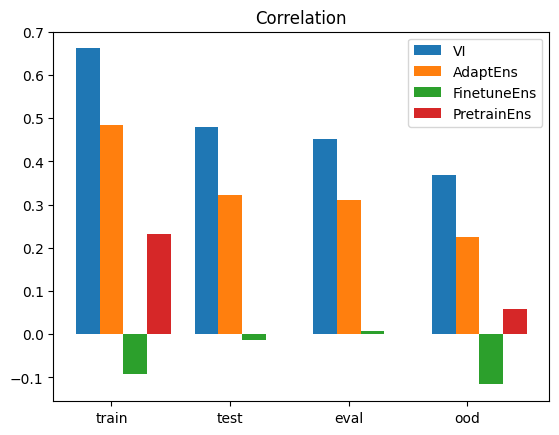

In [38]:
x_labels = ['VI', 'AdaptEns', 'FinetuneEns', 'PretrainEns']
bar_labels = ['train', 'test', 'eval', 'ood']
# Set the width of the bars
bar_width = 0.2

# Generate some random data for the bars
data = np.array([[0.6614296494944618, 0.4840945267028453 ,-0.09131798391076847 , 0.23106520440146183], [0.47892330221793167, 0.322236670433129, -0.014102754498991945, 0.0], [0.45251092137986665, 0.30988203179789975, 0.006720589136532155, 0.0], [0.36932937182651315, 0.22402185570435587, -0.11646054855009284, 0.05782040031539965]])

# Create an array with the positions of each bar along the x-axis
x_pos = np.arange(len(bar_labels))

# For each set of bars: position, label, and data
for i in range(len(x_labels)):
    plt.bar(x_pos + i * bar_width, data[:, i], width=bar_width, label=x_labels[i])

# Set the name of each x-axis label and the title of the plot
plt.xticks(x_pos + bar_width, bar_labels)
plt.title('Correlation')

# Adding the legend and showing the plot
plt.legend()
plt.show()